In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
import pandas as pd
import pickle
import glob
from matplotlib import pyplot as plt

#!pip install Pillow==4.0.0
#!pip install PIL
#!pip install image
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import models

%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

In [16]:
IMG_DIR = 'spectrogram_dataset/' # was 'spectrogram_images/'
IMG_HEIGHT = 1024                # was 216 
IMG_WIDTH = 256                  # was 216
IMG_CHANNELS = 3                 # change to 1
NUM_CLASSES = 3                  # was 7
NUM_EPOCHS = 3                   # was 10
BATCH_SIZE = 4                   # was 32
L2_LAMBDA = 0.001

In [26]:
# Randomly select 1 spectrogram from each category for plotting
# sample_files = ['0002_hiphop.jpg',
#                 '0001_hiphop.jpg',
#                 '0002_reggae.jpg',
#                 '0001_reggae.jpg',
#                 '0002_classical.jpg',
#                 '0001_classical.jpg']

# label_dict = {'classical': 0,
#               'hiphop': 1,
#               'reggae': 2
#              }

sample_files = ['0000_disco.jpg',
                '0001_disco.jpg',
                '0100_classical.jpg',
                '0101_classical.jpg',
                '0202_rock.jpg',
                '0201_rock.jpg']

label_dict = {'disco': 0,
              'classical': 1,
              'rock': 2
             }

one_hot = OneHotEncoder(n_values=NUM_CLASSES)

# get all files (remove hidden files)
all_files = [f for f in os.listdir(IMG_DIR) if not f.startswith('.')]

# Get class weights
label_array = []
for file_ in all_files:
    split_index = len(file_)-file_.find('.') # split before data type
    vals = file_[:-split_index].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
    classes = np.unique(label_array), y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, label_array, random_state = 10, test_size = 0.5)

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, random_state = 10, test_size = 0.1)

#train_labels = tf.contrib.keras.utils.to_categorical(train_labels, num_classes=NUM_CLASSES)
#test_labels = tf.contrib.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)
#val_labels = tf.contrib.keras.utils.to_categorical(val_labels, num_classes=NUM_CLASSES)

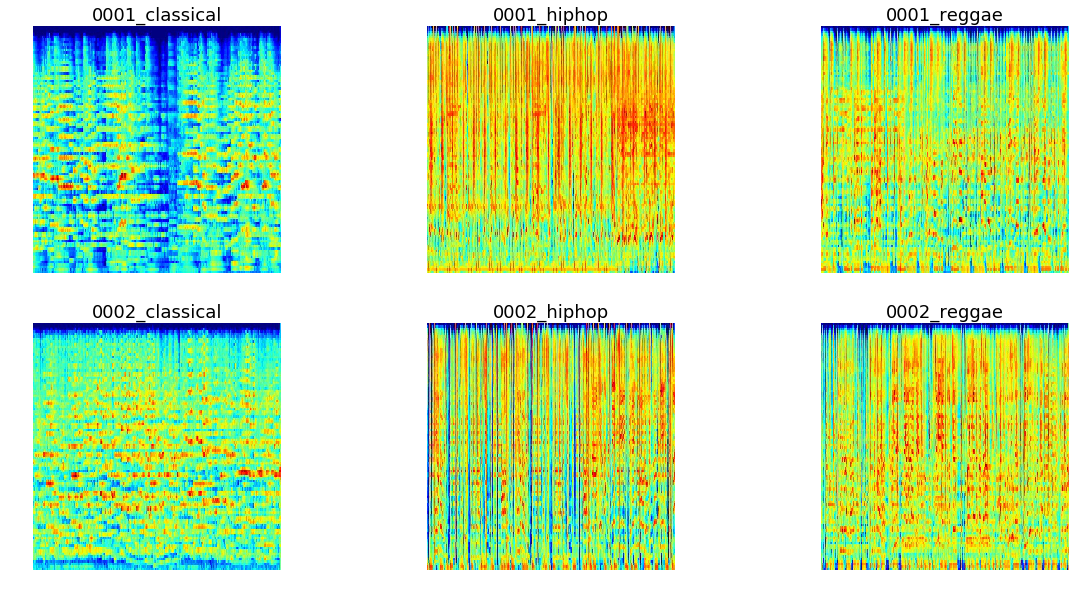

In [27]:
f, axarr = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2), 
              (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    with Image.open(IMG_DIR+file_) as im:
        #im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
        axarr[coordinates[i]].imshow(np.asarray(im))
        axarr[coordinates[i]].axis('off')
        axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)

Samples above show that the spectrograms are different for different genres.

In [20]:
conv_base = tf.contrib.keras.applications.VGG16(
    include_top = False, weights = 'imagenet', 
    input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # 3 channels - RGB 
# The weights are for the CONV filters - hence you can pass any pre-set image size to this VGG network
# Need not be 224 x 224 x 3 (Although does it work better for 224 size? Need to check)

In [21]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [22]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 3)                 1539      
Total params: 35,950,403.0
Trainable params: 35,950,403.0
Non-trainable params: 0.0
__________________________________________________________

In [23]:
# Set the convolution base to be trainable
conv_base.trainable = True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 3)                 1539      
Total params: 35,950,403.0
Trainable params: 35,950,403.0
Non-trainable params: 0.0
__________________________________________________________

In [24]:
# Load the transfer learning model and use its dense network to initialize the weights of the fine-tune model
#tl_model = models.load_model(filepath='saved_models/transfer_learning_epoch_02_0.6306.h5') # 02 is epoch 3
tl_model = models.load_model(filepath='saved_models/transfer_learning_epoch_02_1.0000.h5')
tl_model.weights[-4:] # The weights from the 2 dense layers have to be transferred to the new model

[<tf.Variable 'dense_1_3/kernel:0' shape=(18432, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1_3/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_output_3/kernel:0' shape=(512, 3) dtype=float32_ref>,
 <tf.Variable 'dense_output_3/bias:0' shape=(3,) dtype=float32_ref>]

In [25]:
for i in range(1, len(model.layers)): # The first layer (index = 0) is the conv base
    model.layers[i].set_weights(tl_model.layers[i].get_weights())

ValueError: Layer weight shape (41472, 512) not compatible with provided weight shape (18432, 512)

In [12]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        #im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.swapaxes(np.array(im), 0, 1))
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])
        im.close()

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [13]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [14]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'
#TODO: check these:
#loss = 'sparse_categorical_crossentropy'
#loss = 'binary_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/fine_tuning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

print('Amount of training data:  ', np.shape(train_labels))
print('Amount of validation data:', np.shape(test_labels))
print('Amount of testing data:   ', np.shape(val_labels))
print('Start training...')
history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

Epoch 1/10
8/8 [==============================] - 31s - loss: 1.7793 - categorical_accuracy: 0.5000 - val_loss: 1.4971 - val_categorical_accuracy: 0.7500
Epoch 2/10
8/8 [==============================] - 28s - loss: 1.1326 - categorical_accuracy: 1.0000 - val_loss: 1.0491 - val_categorical_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 27s - loss: 1.1301 - categorical_accuracy: 1.0000 - val_loss: 0.9967 - val_categorical_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 27s - loss: 1.0214 - categorical_accuracy: 1.0000 - val_loss: 0.9492 - val_categorical_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 27s - loss: 0.9840 - categorical_accuracy: 1.0000 - val_loss: 0.9280 - val_categorical_accuracy: 1.0000
Epoch 6/10
3/8 [==========>...................] - ETA: 18s - loss: 0.9417 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [15]:
# Save scores on train and validation sets
with open('pickle_files/fine_tuning_no_initialization_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [16]:
# Load scores
with open('pickle_files/fine_tuning_no_initialization_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


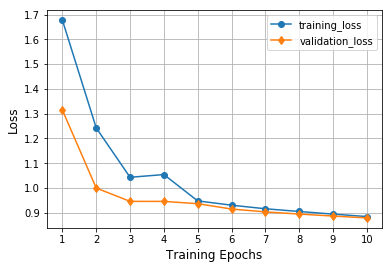

In [17]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-loss.png')

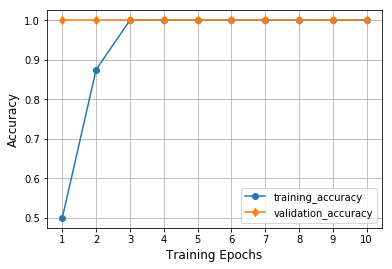

In [18]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-accuracy.png')

Choose epoch 4 to be the model that does well on the validation set (in terms of minimum loss and maximum accuracy).

In [20]:
model = models.load_model(filepath='saved_models/fine_tuning_epoch_02_1.0000.h5')

In [21]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

In [22]:
with open('pred_probas/testset_filenames.txt', 'w') as f:
    f.write('\n'.join([t.split('.')[0]+'.wav' for t in test_files]))

In [23]:
with open('pred_probas/vgg_fine_tuning.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Evaluation of the best performing model

In [24]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[1 0 0]
 [0 1 0]
 [0 1 2]]


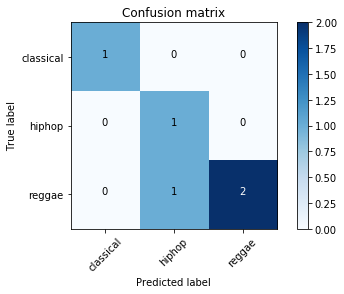

In [25]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [26]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.80
Test Set F-score =  0.82


In [27]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 1.000


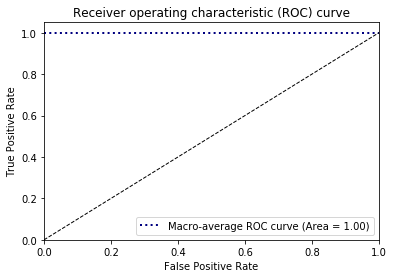

In [28]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()